In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

from dask_image import imread

from cil.framework import AcquisitionGeometry
from cil.io import ZEISSDataReader, TIFFStackReader
from cil.processors import Binner, TransmissionAbsorptionConverter
from cil.recon import FDK

from PIL import Image

### Path to Battery tiff dataset

In [3]:
path = r"Z:\Users\Antony\RSIF\microct\Imperial\Nickel_M8+Li_Fe_S2_full-battery-scan\Scan2"
name = "Nickel_M8+Li_Fe_S2_full-battery-scan0*.tif"
data_dask = imread.imread(os.path.join(path, name)).astype("float32")


C:\Users\Simon\anaconda3\envs\ndtomo_cil\Lib\site-packages\pims\image_sequence.py:85: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  return imread(filename, **kwargs)


In [4]:
data_dask

dask.array<astype, shape=(1801, 1152, 1142), dtype=float32, chunksize=(1, 1152, 1142), chunktype=numpy.ndarray>

In [5]:
num_pixels_y = 1142
num_pixels_x = 1152

FDD=332.99812500
FOD=134.99937500
VoxelSizeX=0.04054058
VoxelSizeY=0.04054058

angles_list = np.linspace(-np.pi, np.pi, 1800, endpoint=False)

ag = AcquisitionGeometry.create_Cone3D( source_position=[0.0, -FOD, 0.0], \
                                        detector_position=[0., FDD ,0.],\
                                        rotation_axis_position=[0, 0., 0.],\
                                        rotation_axis_direction=[0., 0, np.pi] ) \
                        .set_angles(angles = angles_list, angle_unit='radian')\
                        .set_panel( num_pixels=[num_pixels_y, num_pixels_x], \
                                    pixel_size=[VoxelSizeX, VoxelSizeY],\
                                    origin='bottom-left')\
                        .set_labels(['angle','vertical','horizontal'])


ig = ag.get_ImageGeometry()


In [6]:
data = ag.allocate()
data_np = data_dask.compute()
data.fill(data_np[0:1800])

In [7]:
absorb = TransmissionAbsorptionConverter()
absorb.set_input(data)
data_absorbed = absorb.get_output()

In [8]:
data_absorbed -= np.mean(data_absorbed.array[0:100,:,0:10])

In [9]:
fdk_recon = FDK(data_absorbed, image_geometry=ig).run()

FDK recon

Input Data:
	angle: 1800
	vertical: 1152
	horizontal: 1142

Reconstruction Volume:
	vertical: 1152
	horizontal_y: 1142
	horizontal_x: 1142

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



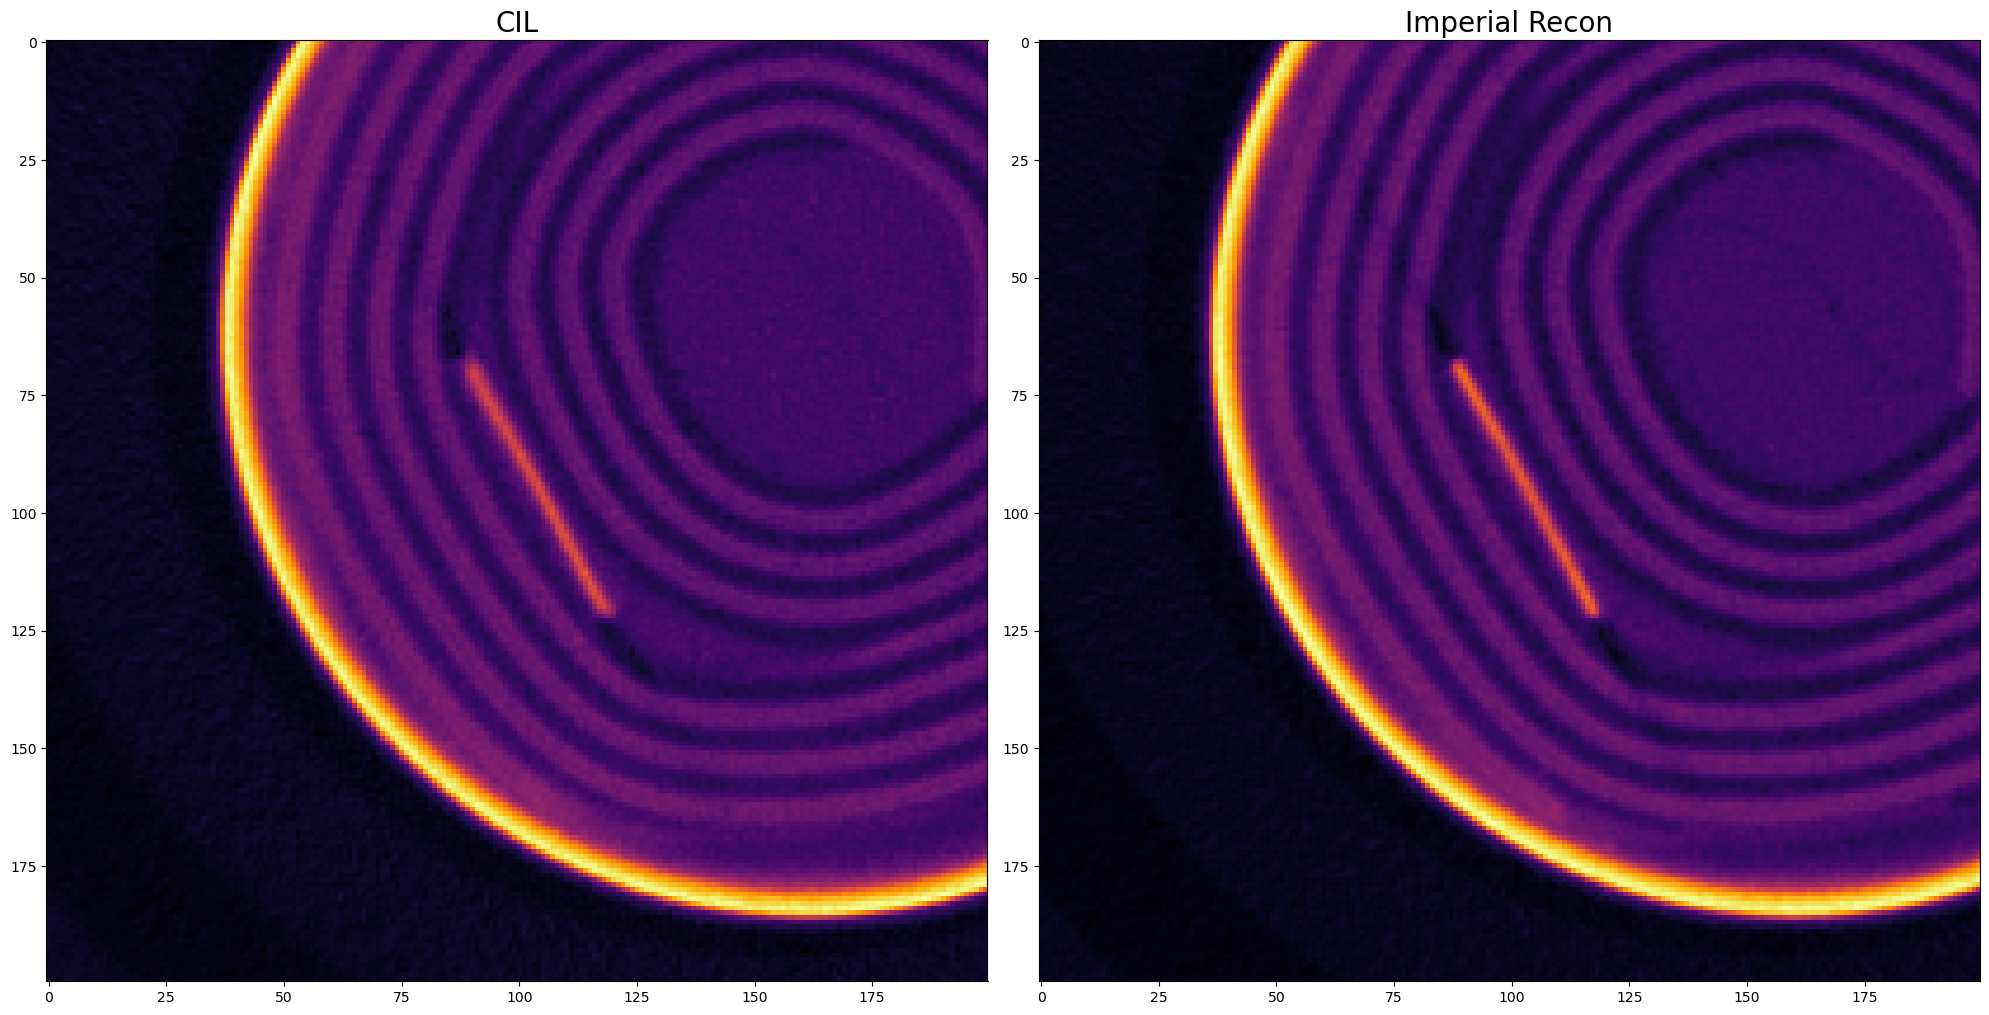

In [12]:
num_slice = 900
path = r"Z:\Users\Antony\RSIF\microct\Imperial\Nickel_M8+Li_Fe_S2_full-battery-scan\Scan2\Li_Fe_S2_full-battery_recon"
name = "Li_Fe_S2_full-battery_recon0{}.tif".format(num_slice)
im = Image.open(os.path.join(path, name))
zz = np.array(im)[500:700,400:600]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(fdk_recon.array[num_slice,500:700,400:600], cmap="inferno")
axs[0].set_title('CIL', fontsize=20)

axs[1].imshow(zz, cmap="inferno")
axs[1].set_title('Imperial Recon', fontsize=20)

plt.tight_layout()

plt.show()